# PHYS 7730 (Data Science) Problem Set Summary
By Kaixin Wang and Prof. Michael Vershinin

## Question 6: Generalized Pareto Distribution
MELE for quantile and use jacobian matrix to propogate the errors

In [11]:
#Let's say we have a lot of generalized pareto i.i.d.r.v.'s
#It is hard to estimate the shape parameter directly
#in a way that would work with empirical likelihood
#As mentioned in class, you are better off estimating something
#easy and then propagating the error. 
#Unfortunately, you quickly discover that moments are not good
#for estimating purposes because they only exist up to Shape parameter 1
#The problem specifically asks for Shape parameters from 1/2 to 2
#This leaves us with the median as a good starting point
#Let's adapt code form problem 2 to our needs here.

%reset -f
import numpy as np
import scipy.optimize as SciOpt
import scipy.stats as SciStat
import scipy.special as SciSpec
from numpy import random as rnd
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.stats.distributions import chi2

Nsamples=int(2e4)
#First we generate the r.v.'s
Shape=2
rvvec=SciStat.genpareto.rvs(Shape,size=Nsamples);
print('The ground truth median is : ' + str((np.power(2,Shape)-1)/Shape))
print('The median of the data is : ' + str(np.median(rvvec)))

The ground truth median is : 1.5
The median of the data is : 1.5367106565438666


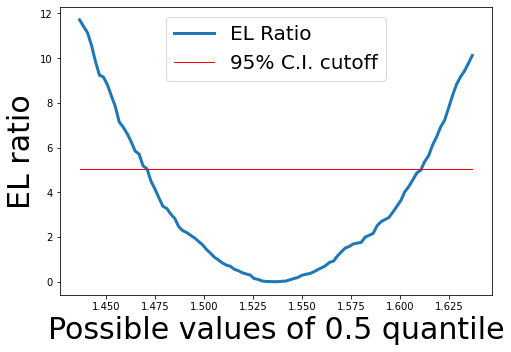

In [12]:
def ELR(data,Val,qVal): 
    #data is (...wait for it...) the vector of data
    #Val is the tentative value for quantity being estimated
    #Lam is the Lagrange multiplier
    #-------------------------------------------------------
    #Define the estimating function
    #The estimating function is an expression which
    #when averaged over the data and set to zero gives the desired
    #condition
    #Here we basically define a function which is 1 for data values
    #below Val and zero above that. When averaged over the entire data
    #set this gives us the actual quantile of Val which we can then
    #force to be qVal and see the resulting ELR from this constraint
    g=(data<Val)-qVal
    #Set up the Lagrange mutiplier condition for Lam
    constraintEQN = lambda L : sum(np.divide(g,1 + g*L)); 
    #Find the multiplier
    Lam=SciOpt.fsolve(constraintEQN,0);
    #return the Empirical Likelihood Ratio
    return 2*np.sum(np.log(1+Lam*g))
#
#Let's pick some value for quantile we want
alpha=0.5
#Let's pick some reasonable range for possible values of the mean
x=np.linspace(np.quantile(rvvec,alpha)-0.1, np.quantile(rvvec,alpha)+0.1,100)
#I will also set up some indexing variable 
t=np.linspace(0,len(x)-1,len(x)).astype(int)
#We will record ELR values in y, so let's start with initializing
#this variable to be all zeros and same size as x
y=0*x
#For every possible mean value in our range compute ELR
for ii in t:
    y[ii]=ELR(rvvec,x[ii],alpha) 
#Plot the output to the user
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
#The ELR curve
plt.plot(x,y,label='EL Ratio', linewidth=3)
#The cutoff line for 95% confidence
plt.plot(x,x*0+chi2.ppf(0.975, df=1),'r',label='95% C.I. cutoff', linewidth=1)
plt.legend(fontsize=20)
plt.xlabel('Possible values of ' + str(alpha) + ' quantile', fontsize=30)
plt.ylabel('EL ratio', fontsize=30)
plt.show()
#While we are at it, let's record the location of minimum ELR
cen=x[np.argmin(y)]

In [13]:
#Define cost function which sets target ELR based on confidence level
ELRiterator = lambda p : ELR(rvvec,p,alpha)-chi2.ppf(0.975, df=1); 
#Use brent method to find intersection point for ELR and cutoff...
#... on the right side of minimum
limHi=SciOpt.brentq(ELRiterator, cen, cen+0.1)
#... on the left side of minimum
limLo=SciOpt.brentq(ELRiterator, cen-0.1, cen)
#Dump output to user
print('The ground truth median is : ' + str((np.power(2,Shape)-1)/Shape))
print('The median of the data is : ' + str(np.median(rvvec)))
print('The 95% CI for MELE :')
print((limLo, limHi))

The ground truth median is : 1.5
The median of the data is : 1.5367106565438666
The 95% CI for MELE :
(1.4711005569326705, 1.611349100736454)


In [14]:
print('Let us look at the sizes of error bars here:')
print((np.median(rvvec)-limLo, limHi-np.median(rvvec)))
#This looks symmetric enough so we will pretend this is the case
errSZmedian=np.max((np.median(rvvec)-limLo, limHi-np.median(rvvec)))

Let us look at the sizes of error bars here:
(0.06561009961119613, 0.07463844419258736)


In [15]:
#Now the rest is basically following examples in class
#but in this case the function relating median and C is 
#median=(2^C-1)/C
func = lambda C : -np.median(rvvec)+(np.power(2,C)-1)/C
#we will call a numerical solver with the initial guess log(2)
#This initial guess is motivated as follows:
#2^C ~ 1+C*log(2) via Taylor series and also
#2^X = 1+C*median from formula for median
#so this is a decent starting guess for small C (C<2)
res = SciOpt.root(func, np.log(2));
print('The ground truth shape parameter : ', Shape)
print('The recovered shape parameter :  ', res.x[0])
#And we should also get the derivative at this root for free...
ErrSZ=errSZmedian/abs(res.fjac[0][0]*res.r[0])    ### fjac*r is the q*r=jacobian matrix
#MLE + error propagation CI
print('MELE 95% CI : ', end = '')
print((res.x[0]-ErrSZ, res.x[0]+ErrSZ))

The ground truth shape parameter :  2
The recovered shape parameter :   2.0568610396884273
MELE 95% CI : (1.9429166582132986, 2.1708054211635557)
